In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [4]:
#1 Preprocessing
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add domain-specific stop words
domain_stop_words = {'thank', 'please', 'feel', 'best','''I've''','ive','''I'm''','im', 'regards'}
stop_words.update(domain_stop_words)

def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Remove short words (length < 3)
    tokens = [token for token in tokens if len(token) > 2]
    return ' '.join(tokens)

In [52]:
#grab the data from where it's stored
survey_responses = pd.read_csv('/Users/jamikapage/Library/Mobile Documents/com~apple~CloudDocs/Portfolio/Question/Combined_Feedback_Data.csv')

In [54]:
survey_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       1000 non-null   int64 
 1   Gender    1000 non-null   object
 2   Location  1000 non-null   object
 3   Feedback  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [56]:
survey_responses.replace([np.inf, -np.inf], np.nan, inplace=True)

In [58]:
# Preprocess the survey responses
processed_responses = [preprocess_text(response) for response in survey_responses['Feedback']]

In [60]:
print(processed_responses)

['getting way many reminder email overwhelming', 'customer service topnotch every time reached', 'wish flexibility payment plan', 'find portal easy navigate able pay bill quickly', 'customer service topnotch every time reached', 'customer service take long respond reach problem', 'love new payment option added convenient', 'setting payment plan seamless really helped manage finance better', 'really appreciate ability set automatic payment', 'setting payment plan seamless really helped manage finance better', 'half time email straight spam miss important reminder', 'bombarded many notification make difficult keep track whats important', 'customer service take long respond reach problem', 'online system work perfectly never experienced trouble platform', 'wish flexibility payment plan', 'interface userfriendly really intuitive welldesigned', 'everything work fine issue whatsoever', 'half time email straight spam miss important reminder', 'feel like system always issue trying make payment

In [62]:
# Functions
# Create a document-term matrix using TF-IDF
tfidf = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1, 3))
doc_term_matrix = tfidf.fit_transform(processed_responses)

feature_names = tfidf.get_feature_names_out()

In [64]:
# Function to print top words for each topic
def print_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

In [90]:
# Function to create a single overall word cloud
def create_overall_wordcloud(model, feature_names, num_top_words):
    # Accumulate top words from all topics
    overall_top_words = {}

    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for the current topic
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_top_words - 1:-1]}
        
        # Add the word frequencies to the overall dictionary (accumulate across topics)
        for word, score in top_words.items():
            if word in overall_top_words:
                overall_top_words[word] += score  # Sum the importance scores
            else:
                overall_top_words[word] = score

    # Generate the word cloud from the overall accumulated top words
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(overall_top_words)

    # Display the word cloud
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('overall_wordcloud.png')
    plt.show()
    plt.close()

In [68]:
# Function to create word clouds
def create_wordcloud(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_top_words - 1:-1]}
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(top_words)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_idx + 1} Word Cloud')
        plt.savefig(f'topic_{topic_idx+1}_wordcloud.png')
        plt.show()
        plt.close()

In [70]:
# Function to calculate coherence score
def calculate_coherence_sklearn(lda_model, texts, feature_names):
    # Get topic-word distributions
    topic_word_dist = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    
    # Convert to gensim format
    topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in topic_word_dist]
    
    # Create gensim dictionary
    dictionary = Dictionary(texts)
    
    # Calculate coherence
    cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

In [72]:
# Topic Modeling
# Perform topic modeling using LDA
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, doc_topic_prior=0.1, topic_word_prior=0.1)
lda_output = lda_model.fit_transform(doc_term_matrix)

# Print LDA topics
print("LDA Topics:")
print_topics(lda_model, tfidf.get_feature_names_out(), 10)

LDA Topics:
Topic 1: intuitive welldesigned, interface userfriendly, interface, userfriendly really, userfriendly really intuitive, interface userfriendly really, intuitive, really intuitive, welldesigned, really intuitive welldesigned
Topic 2: reminder, perfect right amount, right amount, reminder perfect right, amount, right, reminder perfect, perfect, perfect right, issue whatsoever
Topic 3: payment, really, manage finance, payment plan seamless, setting, setting payment, setting payment plan, manage, seamless really helped, seamless really
Topic 4: customer service, reached, time reached, every time reached, topnotch every, service topnotch every, service topnotch, topnotch every time, customer service topnotch, every time
Topic 5: billing, system, easy use, complaint, easy use complaint, use, use complaint, billing portal, billing portal easy, portal easy use


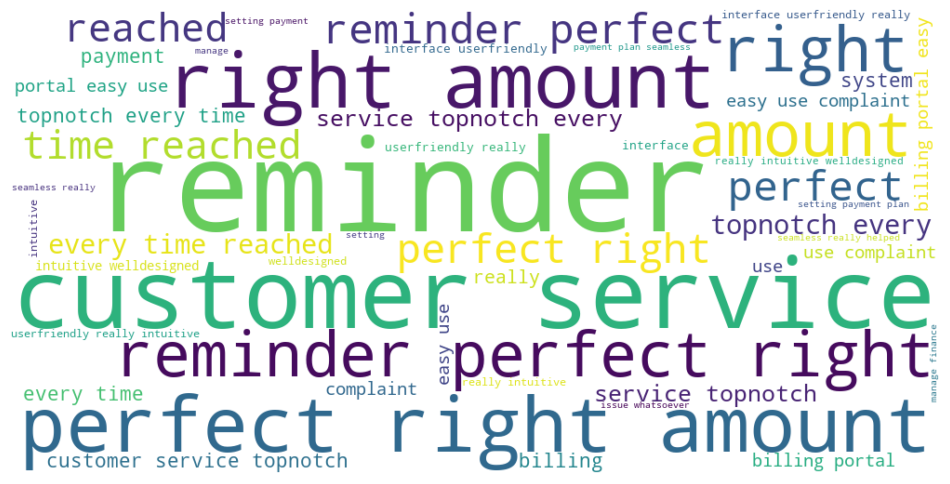

In [92]:
#Create overall word cloud for LDA topics
create_overall_wordcloud(lda_model, feature_names, 10)

In [ ]:
# Create word clouds for LDA topics
create_wordcloud(lda_model, tfidf.get_feature_names_out(), 10)

In [76]:
# Calculate and print LDA coherence score
# Ensure processed_responses is tokenized
processed_responses1 = [response.split() for response in processed_responses]

# Create gensim dictionary
dictionary = Dictionary(processed_responses1)

# Generate topics using the feature names
topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in lda_model.components_]

# Calculate coherence
coherence_model = CoherenceModel(topics=topics, texts=processed_responses1, dictionary=dictionary, coherence='c_v')
lda_coherence = coherence_model.get_coherence()

print(f"LDA Coherence Score: {lda_coherence:.2f}")

lda_coherence = calculate_coherence_sklearn(lda_model, processed_responses1, tfidf.get_feature_names_out())
print(f"LDA Coherence Score: {lda_coherence:.2f}")

LDA Coherence Score: 0.90
LDA Coherence Score: 0.90


In [78]:
# Perform topic modeling using NMF
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_output = nmf_model.fit_transform(doc_term_matrix)

# Print NMF topics
print("\nNMF Topics:")
print_topics(nmf_model, tfidf.get_feature_names_out(), 10)


NMF Topics:
Topic 1: service topnotch every, every time reached, customer service topnotch, topnotch every time, topnotch every, topnotch, time reached, reached, every time, every
Topic 2: new payment option, new payment, love, love new, added, love new payment, option added convenient, new, added convenient, convenient
Topic 3: plan, payment plan, helped manage finance, manage, payment plan seamless, better, finance better, manage finance better, seamless really helped, seamless really
Topic 4: amount, right amount, right, perfect right amount, perfect right, perfect, reminder perfect right, reminder perfect, reminder, often get reminder
Topic 5: responded promptly needed, needed help, promptly needed help, help, happy service customer, happy service, customer support, customer support always, support always responded, support always


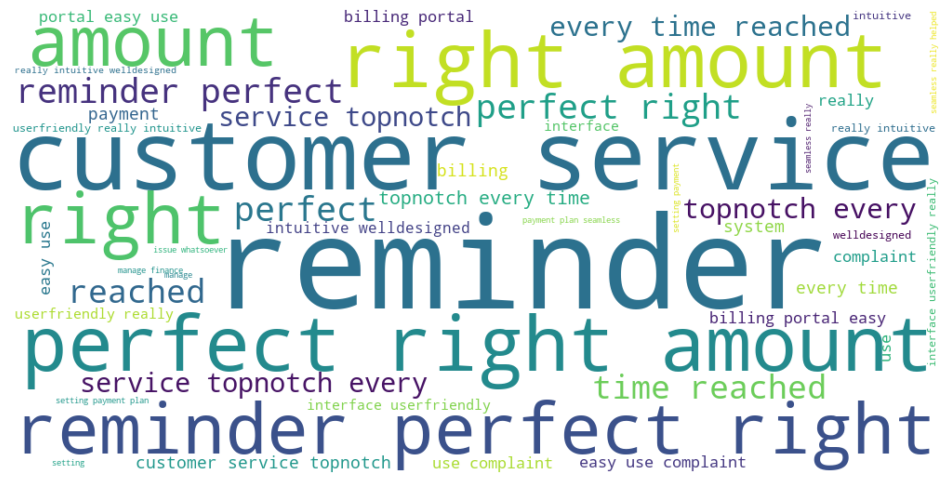

In [94]:
# Create Overall word clouds for NMF topics
create_overall_wordcloud(lda_model, tfidf.get_feature_names_out(), 10)

In [ ]:
# Create word clouds for NMF topics
create_wordcloud(nmf_model, tfidf.get_feature_names_out(), 10)

In [82]:
# Calculate and print NMF coherence score
nmf_coherence = calculate_coherence_sklearn(nmf_model, processed_responses1, tfidf.get_feature_names_out())
print(f"NMF Coherence Score: {nmf_coherence:.2f}")

NMF Coherence Score: 1.00


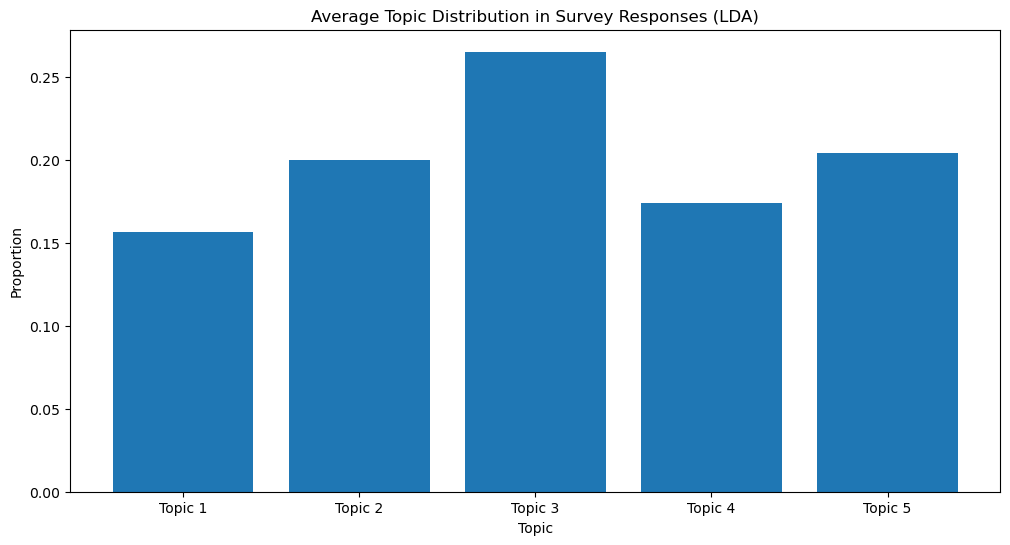


Topic distribution chart saved as 'lda_topic_distribution.png'


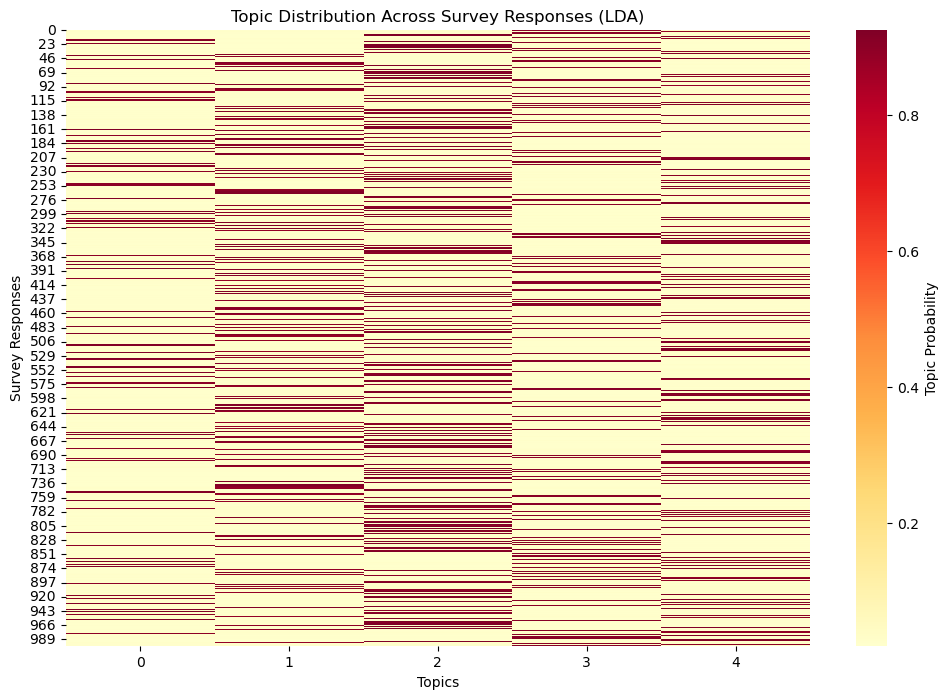

Topic heatmap saved as 'lda_topic_heatmap.png'


In [84]:
# Visualize topic distribution for LDA

plt.figure(figsize=(12, 6))
topic_proportions = lda_output.mean(axis=0)
plt.bar(range(num_topics), topic_proportions)
plt.title('Average Topic Distribution in Survey Responses (LDA)')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.xticks(range(num_topics), [f'Topic {i+1}' for i in range(num_topics)])
plt.savefig('lda_topic_distribution.png')
plt.show()
plt.close()
print("\nTopic distribution chart saved as 'lda_topic_distribution.png'")

# Create a heatmap of topic distribution across responses for LDA
plt.figure(figsize=(12, 8))
sns.heatmap(lda_output, cmap='YlOrRd', cbar_kws={'label': 'Topic Probability'})
plt.title('Topic Distribution Across Survey Responses (LDA)')
plt.xlabel('Topics')
plt.ylabel('Survey Responses')
plt.savefig('lda_topic_heatmap.png')
plt.show()
plt.close()
print("Topic heatmap saved as 'lda_topic_heatmap.png'")

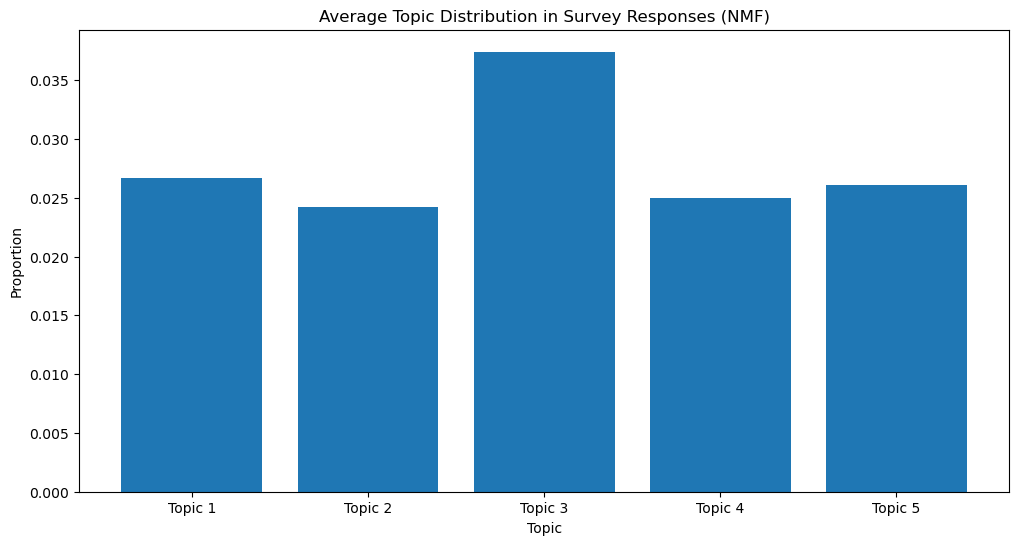

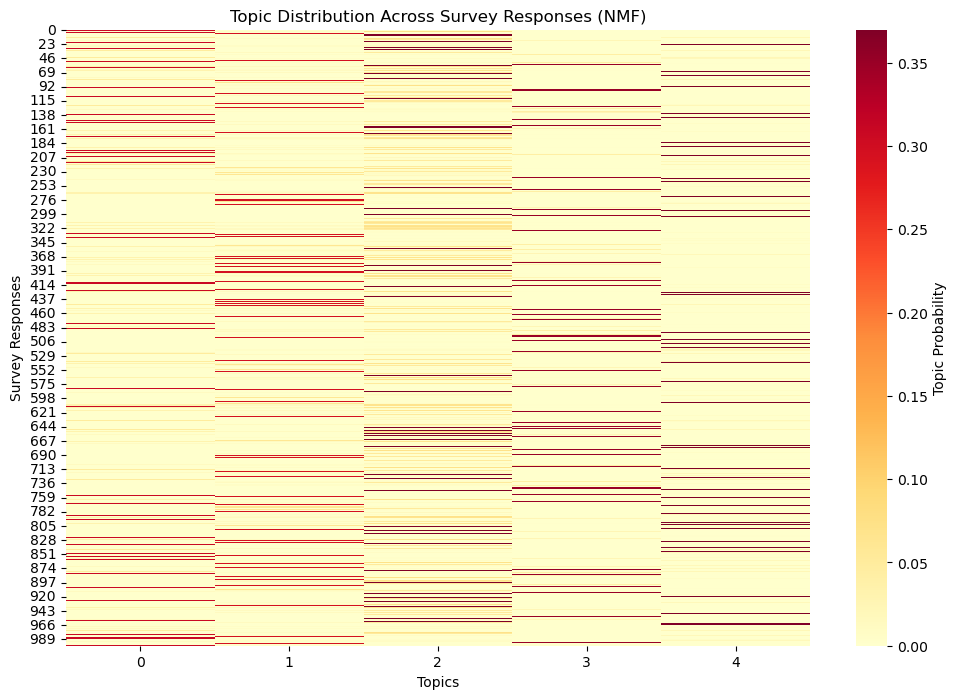

In [86]:
# Visualize topic distribution for NMF
plt.figure(figsize=(12, 6))
nmf_topic_proportions = nmf_output.mean(axis=0)
plt.bar(range(num_topics), nmf_topic_proportions)
plt.title('Average Topic Distribution in Survey Responses (NMF)')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.xticks(range(num_topics), [f'Topic {i+1}' for i in range(num_topics)])
plt.savefig('nmf_topic_distribution.png')
plt.show()
plt.close()

# Create a heatmap of topic distribution across responses for NMF
plt.figure(figsize=(12, 8))
sns.heatmap(nmf_output, cmap='YlOrRd', cbar_kws={'label': 'Topic Probability'})
plt.title('Topic Distribution Across Survey Responses (NMF)')
plt.xlabel('Topics')
plt.ylabel('Survey Responses')
plt.savefig('nmf_topic_heatmap.png')
plt.show()
plt.close()

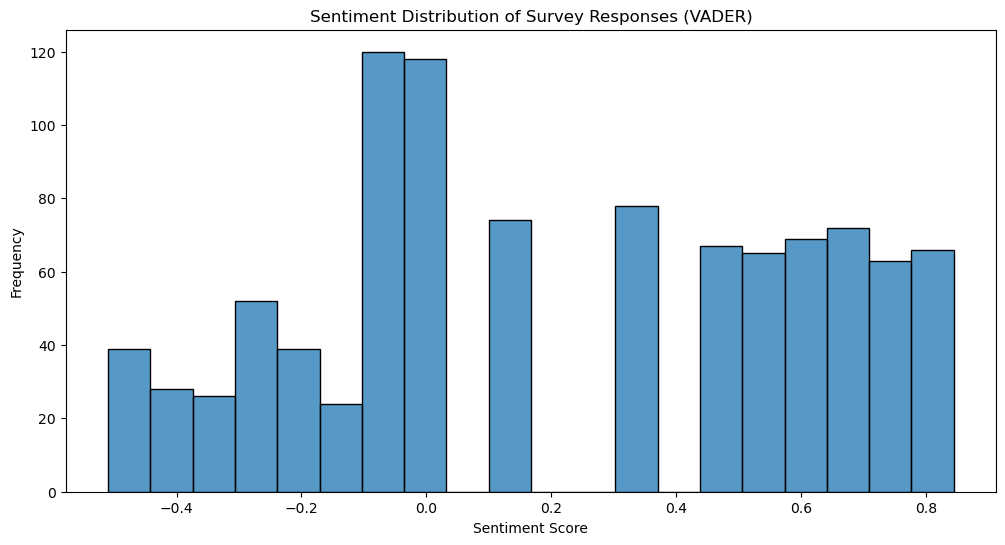

VADER sentiment distribution chart saved as 'vader_sentiment_distribution.png'


In [88]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment using VADER
def vader_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']

# Analyze sentiment using VADER
vader_sentiments = [vader_sentiment(response) for response in survey_responses['Feedback']]
vader_sentiments_clean = np.nan_to_num(vader_sentiments, nan=0.0, posinf=1.0, neginf=-1.0)

# Plot sentiment distribution using VADER
plt.figure(figsize=(12, 6))
sns.histplot(vader_sentiments_clean, bins=20, edgecolor='black')
plt.title('Sentiment Distribution of Survey Responses (VADER)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('vader_sentiment_distribution.png')
plt.show()
plt.close()

print("VADER sentiment distribution chart saved as 'vader_sentiment_distribution.png'")